# Building Footprint Prediction on WorldView-3 Satellite Images

*Written by: Men Vuthy, 2022*

---


You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1a_SkW3HoAKP-dUNFQTyhhlL6j3Y0AmUg#scrollTo=5OyNzz48aOIg)

Building a semantic segmentation model is a thing, another thing is how to apply the model to predict on foreign images. In this section, I will use my pretrained UNet model to extract building footprint from foreign satellite images by maintaining the original metadata such as coordinate reference, shape, extent, etc.

### Objective

*   Extracting building footprint from WV-3 satellite image by using pretrained UNet model.
*   Resize output mask to original image shape and save as ``GeoTiff`` file.





### Code

**1. Predict building area using pretrained UNet model**

Install modules and import all necessary datasets

In [1]:
import os, cv2
import numpy as np
import pandas as pd

In [2]:
!pip install -q -U albumentations

In [3]:
import random
import albumentations as album

In [4]:
print(album.__version__)

1.1.0


In [5]:
import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [6]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [7]:
!pip install -q torch_snippets pytorch_model_summary

In [8]:
import os, cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch_snippets import *
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from natsort import natsorted
from sklearn.model_selection import train_test_split

In [9]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [10]:
!kaggle datasets download -d menvuthy/pretrained-model-for-building-footprint-extraction
!unzip pretrained-model-for-building-footprint-extraction

pretrained-model-for-building-footprint-extraction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pretrained-model-for-building-footprint-extraction.zip
replace best_model.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: best_model.pth          
  inflating: reference.txt           


Defining predict directory 📁

In [11]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/output/wv3-images/image-8b'


x_predict_dir = os.path.join(DATA_DIR)

Specific classes to segment

In [12]:
class_dict = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/output/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

Helper functions for viz. & one-hot encoding/decoding

In [13]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(15,5))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

Model Definition

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Pretrained UNet Model
best_model = torch.load('/content/best_model.pth', map_location=DEVICE)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Functions to pre-process datasets

In [15]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

# Center crop padded image / mask to original image dims
def crop_heatmap(image, target_image_dims=[1500,1500]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [16]:
def get_prediction_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor))
        
    return album.Compose(_transform)

In [17]:
class PredictDataset(torch.utils.data.Dataset):
  def __init__(self, images_dir, class_rgb_values=None, augmentation=None, preprocessing=None):
    self.image_paths = [os.path.join(images_dir, image_id) for image_id in natsorted(os.listdir(images_dir))]
    self.class_rgb_values = class_rgb_values
    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __len__(self):
        return len(self.image_paths)

  def __getitem__(self, i):
    # image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
    image = cv2.imread(self.image_paths[i])
    image = cv2.resize(image, (1500,1500))

    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=image)
      image = sample['image']

    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=image)
      image = sample['image']

    return image

Read input data

In [18]:
predict_dataset = PredictDataset(
    x_predict_dir, 
    augmentation=get_prediction_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

predict_dataset_vis = PredictDataset(
    x_predict_dir, 
    # augmentation=get_prediction_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

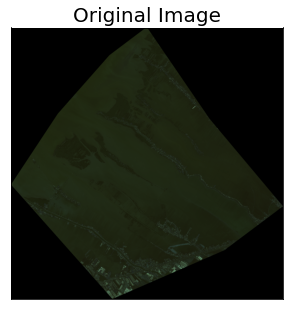

In [19]:
# get a random test image/mask index
random_idx = random.randint(0, len(predict_dataset_vis)-1)
image = predict_dataset_vis[random_idx]

visualize(
    original_image = image
)

In [20]:
sample_preds_folder = '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/output/prediction/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

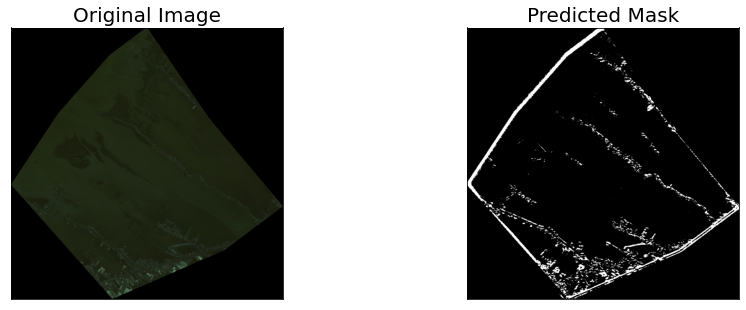

In [21]:
for idx in range(len(predict_dataset)):

    image = predict_dataset[idx]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Write predicted mask
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), pred_mask)
    visualize(
        original_image = predict_dataset_vis[idx],
        predicted_mask = pred_mask,
    )

**2. Resize output mask and export as raster file**

Import necessary modules

In [22]:
!pip install rasterio

In [23]:
import rasterio
from rasterio.plot import show

In [24]:
# Read shape of predicted mask
pred_mask.shape

(1500, 1500, 3)

After prediction, the mask size is (1500, 1500, 3) which is different from the original size. Therefore, we need to resize it so that it fits the input image. To resize, we need to recall the original image to retrieve the shape.

In [25]:
# Read original image
raster = rasterio.open('/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/output/wv3-images/image-8b/image001.tiff')

In [26]:
# Check original shape
raster.shape

(14519, 13015)

As you can see, the original shape is (14519, 13015), so in order to resize, we can use a function called `cv2.resize()`, but the input is not `pred_mask` but `pred_building_heatmap`. 

In [27]:
# Resize predicted mask
mask = cv2.resize(pred_building_heatmap, (raster.shape[1],raster.shape[0]))

In [28]:
# Check shape of mask
mask.shape

(14519, 13015)

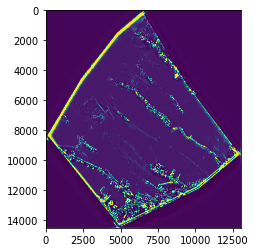

In [29]:
# Visualize the mask
plt.imshow(mask)

So now, we have a mask with the same shape as the original image. Next, let's export it to ``.tiff`` using the following method:

In [30]:
# Data dir
data_dir = "/content"

# Output raster
out_tif = os.path.join(data_dir, "predicted_mask.tiff")

# Copy the metadata
out_meta = raster.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': mask.shape[1],
                 'height': mask.shape[0],
                 'crs': raster.crs,
                 'count': 1,
                 'transform': raster.transform
                })

# Write image
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(mask.astype('float32'), indexes = 1)

Confirm if the mask is exported correctly.

In [31]:
# Read original image
mask_tiff = rasterio.open('/content/predicted_mask.tiff')

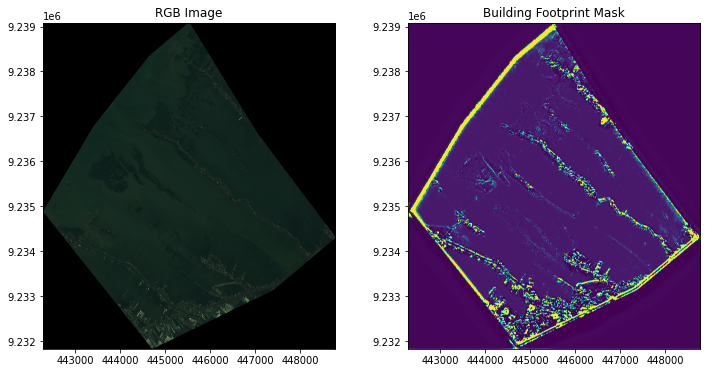

In [32]:
# Visualize RGB image and predicted mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot RGB image
show(raster, ax=ax1)
ax1.set_title('RGB Image')

# Plot building footprint
show(mask_tiff, ax=ax2)
ax2.set_title('Building Footprint Mask')

plt.show();

This is how to make prediction on foreign satellite image to extract building footprint and resize the predicted mask to original size. As can be seen, the result of prediction is not yet perfect because it is only for method demonstration; however, it can be improved with more training data. 

---
